# Tutorial on Data Preparation

## Summary

In this document, we show how to use our program to get simulations of evolutionary results from both balanced binary tree and comb tree. The evolutionary process is modeled by JC69, and we use obtained simulations to estimate the expectation of $MM^{T}$. For evolutions on real tree, we use *pyvolve* to simulate evolved sequences. In this tutorial, we will only use our code to generate simulated data, and we store these data for further analysis using *R*.

## 1. Complete Binary Balanced Tree

### 1.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import itertools
import math
import random
import copy
from _collections import defaultdict
from itertools import product

### 1.2 Complate Binary Balanced Tree Class

In this section, we show how to use the defined *CompleteBinaryBalancedTree* class to simulate evolutionary results. The defined class has 5 instance variables:

- *seq_len*: length of evolving root sequence

- *p*: parameter to weigh the possibility for A, T, C, and G

- *level*: height of the binary tree plus one

- *lam*: parameter in the JC69 model

- *rand_seed*: random seed to control the randomness in root sequence initilization

In [3]:
class CompleteBinaryBalancedTree:
    def __init__(self, seq_len, p, level, lam, rand_seed):
        self.seq_len = seq_len  # length of the initial sequence (sequence of the root)

        self.p = p  # mixing parameter for nucleotides to generate the sequence at the root

        self.level = level  # height of the tree + 1

        self.lam = lam  # only parameter in JC model

        self.seed = rand_seed  # random seed for generating the initial sequence

        self.num_odd_site = math.floor(self.seq_len / 2)

        self.num_even_site = int(self.seq_len - math.floor(self.seq_len / 2) - 1)

    def dyadic_to_real(self, seq):  # transform a dyadic sequence to a real number
        return sum(seq / 2 ** np.linspace(1, len(seq), num=len(seq)))

    def rand_seq(self):  # generate a random initial state
        random.seed(self.seed)
        seq = ['A', 'T', 'C', 'G']
        return ''.join(random.choices(seq, weights=(self.p[0], self.p[1], self.p[2], self.p[3]), k=self.seq_len))

    # One step evolution for a single sequence

    def evolve(self, sequence, dist):
        p0 = 0.25 + 0.75 * math.exp(-4 * self.lam * dist)  # no mutation

        full = {'A', 'T', 'C', 'G'}
        res = []

        for i in range(len(sequence)):
            if np.random.uniform() > p0:
                res.extend(random.sample(full - set(sequence[i]), k=1))
            else:
                res.append(sequence[i])

        return res

    # Build a hash-map with keys being nodes and values being gene expression

    def evolve_map(self):

        dic = defaultdict(list)
        dic[str(self.tips(1)[0])] = list(self.rand_seq())  # initial sequence at the root node

        for d in range(2, self.level + 1):
            nodes = self.tips(d)
            for i in range(0, len(nodes), 2):
                common = self.close_common_node(nodes[i], nodes[i + 1])
                dic[str(nodes[i])] = self.evolve(dic[str(common)], 0.5 ** d)
                dic[str(nodes[i + 1])] = self.evolve(dic[str(common)], 0.5 ** d)

        return dic

    # Count the frequency of mer in a sequence

    def count_mers(self, sequence: str, mer: str):  # count the frequency of mer in a sequence
        i = 0
        cnt = 0
        while i + len(mer) - 1 < len(sequence):
            if sequence[i:(i + len(mer))] == mer:
                cnt += 1
            i += 1
        return cnt

    # One realization of MM^T under k-mer based on JC evolutionary model

    def sim_mmt_kmer(self, k):
        one_sim = self.evolve_map()

        tips = self.tips(self.level)

        M = np.empty(shape=(len(tips), 4 ** k))
        letters = ['A', 'T', 'C', 'G']
        mers = [''.join(letter) for letter in product(letters, repeat=k)]

        # source:
        # https://stackoverflow.com/questions/7074051/what-is-the-best-way-to-generate-all-possible-three-letter-strings

        for i in range(len(tips)):
            for j in range(len(mers)):
                M[i][j] = self.count_mers(''.join(one_sim[str((tips[i]))]), mers[j])


        return np.matmul(M, M.transpose())

    # Simulations of multiple evolution results

    def sim_eig(self, nsim, k):
        res = np.zeros(shape=(2 ** (self.level - 1), 2 ** (self.level - 1)), dtype=float)
        for iter in range(nsim):
            sim_mat = self.sim_mmt_kmer(k)
            res += sim_mat
        mean_mat = res * (1 / nsim)
        eigvals, eigvecs = np.linalg.eigh(mean_mat)
        rev_eigvals = eigvals[::-1]
        rev_eigvecs = eigvecs[:, ::-1]
        return mean_mat, rev_eigvals, rev_eigvecs

    # Find the closest common ancestral node given two nodes a and b are at the
    # same level

    def same_level_node(self, a, b):
        if len(a) == 0 or len(b) == 0:
            import warnings
            warnings.warn("a and b must be nonempty")

        if len(a) != len(b):
            import warnings
            warnings.warn("a and b must be at the same level")

        if len(a) == len(b):
            # When a and b are the same node, their closest ancestral node is itself
            if a == b:
                return a
            else:
                # element wise equality
                vec = np.equal(a, b)
                # find the position of at the first time a and b differ
                pos = min(min(np.where(vec == 0)))

            if pos == 0:
                # Closest node is the root
                return [1]
            else:
                node = a[0:pos]
                node.append(1)
                return node

    def close_common_node(self, a, b):  # find the closest common ancestral node for pair of nodes

        if len(a) == 0 or len(b) == 0:
            import warnings
            warnings.warn("a and b must be nonempty")

        # When a and b are at the same level
        if len(a) == len(b):
            return self.same_level_node(a, b)

        # When at least one is at a different level
        else:
            if a[0] != b[0]:
                return [1]
            elif len(a) > len(b):
                old = b
                young = a
                while len(young) != len(old):
                    young = young[:-2]
                    young.append(1)
                return self.same_level_node(young, old)
            elif len(a) < len(b):
                old = a
                young = b
                while len(young) != len(old):
                    young = young[:-2]
                    young.append(1)
                return self.same_level_node(young, old)

    def dist_ances(self, child, ances):  # calculate distance between a node and one of its ancestral node
        if child != ances:
            parent = child[:-2]
            parent.append(1)
            return abs(self.dyadic_to_real(parent) - self.dyadic_to_real(child)) + self.dist_ances(parent, ances)
        else:
            return 0

    def dist_between_nodes(self, n1, n2):  # calculate distance between any pair of nodes n1 and n2
        # Find the closest common ancestral node of node 1 (n1) and node 2 (n2)
        common = self.close_common_node(n1, n2)
        return self.dist_ances(n1, common) + self.dist_ances(n2, common)

    def tips(self, layer):  # generate all the tips at a specified level
        if layer == 1:
            return [[1]]
        if layer == 2:
            return [[0, 1], [1, 1]]
        if layer > 2:
            # size is the length of each cartesian product
            size = layer - 1
            l = [[0, 1], [0, 1]]
            prod = [[a, b] for a in l[0] for b in l[1]]
            while len(prod[0]) != size:
                l1 = copy.deepcopy(prod)
                l2 = copy.deepcopy(prod)
                for i in l1:
                    i.append(0)
                for i in l2:
                    i.append(1)
                prod = l1 + l2
            # append 1 to the end of each sublist in prod
            # this gives us all the tips at a certain level
            for i in prod:
                i.append(1)

            # I do an additional step to sort the tips so that
            # they are in an increasing order in terms of their values in [0,1]
            X = prod
            Y = []
            for i in prod:
                Y.append(self.dyadic_to_real(i))
            Z = [x for _, x in sorted(zip(Y, X))]
            return Z

    def one_step_transition_mat(self, dist):  # one step transition probability matrix
        return ([[0.25 + 0.75 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 + 0.75 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 + 0.75 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 + 0.75 * math.exp(-4 * self.lam * dist)]])

    # level: level of the tree; root as level 1.
    # dist: distance between nodes; lam: rate parameter
    def edge_mat_map(self):
        edge_len = [1 / 2]
        for i in range(self.level - 1):
            edge_len.append(edge_len[-1] / 2)
        edge_len.pop(0)
        # construct a hash map with keys being one step branch length
        # and values being one step transition matrix
        dic = defaultdict(list)

        for edge in edge_len:
            dic[edge] = self.one_step_transition_mat(edge)

        return dic

    def trans_prob_mat(self, dic, between_dist):  # calculate all necessary transition matrix based on complete
        # binary tree

        # initialize identity matrices
        # mat_full: from root to tips
        # mat_root_to_close: from root to a closest common ancestral node
        # mat_close_to_tip: from closest common ancestral node to tip
        mat_full = [[1, 0, 0, 0], [0, 1, 0, 0],
                    [0, 0, 1, 0], [0, 0, 0, 1]]
        mat_root_to_close = [[1, 0, 0, 0], [0, 1, 0, 0],
                             [0, 0, 1, 0], [0, 0, 0, 1]]
        mat_close_to_tip = [[1, 0, 0, 0], [0, 1, 0, 0],
                            [0, 0, 1, 0], [0, 0, 0, 1]]

        for key in dic:
            mat_full = np.matmul(mat_full, dic[key])
            if key > 0.5 * between_dist:
                mat_root_to_close = np.matmul(mat_root_to_close, dic[key])
            else:
                mat_close_to_tip = np.matmul(mat_close_to_tip, dic[key])
        return mat_full, mat_root_to_close, mat_close_to_tip

    def count_diff_site(self, mer1: str, mer2: str):
        if len(mer1) != len(mer2):
            raise (Exception("Error: two mers should have the same length"))
        cnt = 0
        for i in range(len(mer1)):
            if mer1[i] != mer2[i]:
                cnt += 1
        return cnt

    # records for kmers' index (odd and even) based on a full sequence
    def kmer_pos_table(self, sequence: str, k: int):
        letters = ['A', 'T', 'C', 'G']
        mers = [''.join(letter) for letter in product(letters, repeat=k)]
        dic_odd = defaultdict(tuple)
        dic_even = defaultdict(tuple)
        for i in range(len(sequence) - k + 1):
            if i % 2:
                dic_even[sequence[i:(i + k)]] += (i + 1,)
            else:
                dic_odd[sequence[i:(i + k)]] += (i + 1,)
        return dic_odd, dic_even, mers

    # classify all possible kmer based on hamming distance and returns a hash table
    # with keys being the hamming distance between target_kmer and an arbitrary kmer
    def kmer_class(self, target_kmer: str, all_kmers: [str]):
        dic = defaultdict(list)
        for kmer in all_kmers:
            dic[str(self.count_diff_site(target_kmer, kmer))].append(kmer)
        return dic

    # calculate the g value of a 3-mer
    def g(self, a_3_mer: str):
        cnt = 0
        for i in range(0, 3 - 1):
            if a_3_mer[i] == a_3_mer[i + 1]:
                cnt += 1
        return cnt

    # Given an odd-starting (even-starting) position, count number of non-overlapped
    # even-starting (odd-starting) positions in a tuple.

    def nonoverlapped(self, pos, atuple):
        cnt = 0
        if pos % 2:
            for item in atuple:
                if item != pos - 1 and item != pos + 1:
                    cnt += 1
            return cnt
        else:
            for item in atuple:
                if item != pos - 1 and item != pos + 1:
                    cnt += 1
            return cnt

    # Given a 2mer starting with an odd (even) position, count the number of 2mer that
    # starts with an non-overlapped even (odd) position and with hamming distance 0 or 1 or 2 from given 2mer.

    def count_nonoverlapped(self, mer: str, mers: [str], pos: int, dic_odd, dic_even):
        dic = self.kmer_class(mer, mers)
        sigma_0 = 0
        sigma_1 = 0
        sigma_2 = 0
        if pos % 2:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped(pos, dic_even[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped(pos, dic_even[value])
                    else:
                        sigma_2 += self.nonoverlapped(pos, dic_even[value])
        else:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped(pos, dic_odd[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped(pos, dic_odd[value])
                    else:
                        sigma_2 += self.nonoverlapped(pos, dic_odd[value])
        return sigma_0, sigma_1, sigma_2

    # Given any position, count number of non-overlapped
    # positions in a tuple.

    def nonoverlapped_m1(self, pos, atuple):
        cnt = 0
        for item in atuple:
            if item != pos:
                cnt += 1
        return cnt

    # Given a 2mer, count the number of 2mer that
    # starts with a non-overlapped position and with hamming distance 0 or 1 or 2 from given 2mer.

    def count_nonoverlapped_m1(self, mer: str, mers: [str], pos: int, dic_odd, dic_even):
        dic = self.kmer_class(mer, mers)
        sigma_0 = 0
        sigma_1 = 0
        sigma_2 = 0
        if pos % 2:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped_m1(pos, dic_odd[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped_m1(pos, dic_odd[value])
                    else:
                        sigma_2 += self.nonoverlapped_m1(pos, dic_odd[value])
        else:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped_m1(pos, dic_even[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped_m1(pos, dic_even[value])
                    else:
                        sigma_2 += self.nonoverlapped_m1(pos, dic_even[value])
        return sigma_0, sigma_1, sigma_2

    def em1m2(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)
        three_kmer_dic_odd, three_kmer_dic_even, three_mers = self.kmer_pos_table(s0, k + 1)

        tip = self.tips(self.level)

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):
            for j in range(len(tip)):
                # distance between tip u and tip v
                d_tu_tv = self.dist_between_nodes(tip[i], tip[j])
                x, y, z = self.trans_prob_mat(dic, d_tu_tv)  # mat_full, mat_root_to_close, mat_close_to_tip
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    p0 = x[0][0]
                    p1 = x[0][1]
                    c0 = 0
                    c2 = 0
                    c3 = 0
                    mmt[i][j] = 0
                    for key in three_kmer_dic_odd:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_odd[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_odd[key])
                        else:
                            c3 += len(three_kmer_dic_odd[key])
                    for key in three_kmer_dic_even:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_even[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_even[key])
                        else:
                            c3 += len(three_kmer_dic_even[key])
                    # overlapped case
                    mmt[i][j] += c0 * (p1 ** 3 + 3 * p0 * p1 ** 2) + c2 * (p0 * p1 ** 2 + p0 ** 2 * p1 + 2 * p1 ** 3) \
                                 + c3 * (p0 ** 3 + 3 * p1 ** 3)
                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)], two_mers, indx + 1,
                                                                        two_kmer_dic_odd, two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))

                else:
                    # x, y, z = mat_full, mat_root_to_close, mat_close_to_tip
                    p0cr = y[0][0]
                    p1cr = y[0][1]
                    p0cu = z[0][0]
                    p1cu = z[0][1]
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0

                    # overlapped case
                    for key in three_kmer_dic_odd:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                    for key in three_kmer_dic_even:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)

                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)],
                                                                        two_mers, indx + 1,
                                                                        two_kmer_dic_odd,
                                                                        two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))
        return mmt

    def em2m1(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)
        three_kmer_dic_odd, three_kmer_dic_even, three_mers = self.kmer_pos_table(s0, k + 1)

        tip = self.tips(self.level)

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):

            for j in range(len(tip)):
                # distance between tip u and tip v
                d_tu_tv = self.dist_between_nodes(tip[i], tip[j])
                x, y, z = self.trans_prob_mat(dic, d_tu_tv)
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    p0 = x[0][0]
                    p1 = x[0][1]
                    c0 = 0
                    c2 = 0
                    c3 = 0
                    mmt[i][j] = 0
                    for key in three_kmer_dic_odd:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_odd[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_odd[key])
                        else:
                            c3 += len(three_kmer_dic_odd[key])
                    for key in three_kmer_dic_even:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_even[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_even[key])
                        else:
                            c3 += len(three_kmer_dic_even[key])
                    # overlapped case
                    mmt[i][j] += c0 * (p1 ** 3 + 3 * p0 * p1 ** 2) + c2 * (p0 * p1 ** 2 + p0 ** 2 * p1 + 2 * p1 ** 3) \
                                 + c3 * (p0 ** 3 + 3 * p1 ** 3)
                    # non-overlapped
                    for indx in range(1, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)], two_mers, indx + 1,
                                                                        two_kmer_dic_odd, two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))

                else:
                    p0cr = y[0][0]
                    p1cr = y[0][1]
                    p0cu = z[0][0]
                    p1cu = z[0][1]
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0

                    # overlapped case
                    for key in three_kmer_dic_odd:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                    for key in three_kmer_dic_even:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 3 * p1cu + 2 * p0cu ** 2 * p1cu ** 2 + 6 * p1cu ** 3 * p0cu
                                                + 6 * p1cu ** 2 * p1cu ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                2 * p0cu ** 2 * p1cu ** 2 + 2 * p0cu ** 2 * p1cu ** 2 + 8 * p1cu ** 3 * p0cu
                                                + 4 * p1cu ** 2 * p1cu ** 2)

                    # non-overlapped
                    for indx in range(1, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)],
                                                                        two_mers, indx + 1,
                                                                        two_kmer_dic_odd,
                                                                        two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))
        return mmt

    def em1m1(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)

        tip = self.tips(self.level)

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):

            for j in range(len(tip)):
                # distance between tip u and tip v
                d_tu_tv = self.dist_between_nodes(tip[i], tip[j])
                x, y, z = self.trans_prob_mat(dic, d_tu_tv)
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    for mer in two_mers:
                        sub_class = self.kmer_class(mer, two_mers)
                        c0 = 0
                        c1 = 0
                        c2 = 0
                        for key in sub_class:
                            if key == '0':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c0 += len(two_kmer_dic_odd[item])
                            if key == '1':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c1 += len(two_kmer_dic_odd[item])
                            if key == '2':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c2 += len(two_kmer_dic_odd[item])
                        ex = c0 * p0 ** 2 + c1 * p1 * p0 + c2 * p1 ** 2
                        varx = c0 * p0 ** 2 * (1 - p0 ** 2) + c1 * p1 * p0 * (1 - p0 * p1) + c2 * p1 ** 2 * (
                                1 - p1 ** 2)
                        mmt[i][j] += varx + ex ** 2

                else:
                    p0cr = y[0][0]
                    p1cr = y[0][1]
                    p0cu = z[0][0]
                    p1cu = z[0][1]
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    # overlapped sites
                    mmt[i][j] += math.floor(self.seq_len / 2) * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4) \
                                 * (p0cr ** 2 + 6 * p0cr * p1cr + 9 * p1cr ** 2)

                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped_m1(s0[indx:(indx + k)],
                                                                           two_mers, indx + 1,
                                                                           two_kmer_dic_odd,
                                                                           two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))
        return mmt

    def em2m2(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)

        tip = self.tips(self.level)

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):

            for j in range(len(tip)):
                # distance between tip u and tip v
                d_tu_tv = self.dist_between_nodes(tip[i], tip[j])
                x, y, z = self.trans_prob_mat(dic, d_tu_tv)
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    for mer in two_mers:
                        sub_class = self.kmer_class(mer, two_mers)
                        c0 = 0
                        c1 = 0
                        c2 = 0
                        for key in sub_class:
                            if key == '0':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_even:
                                        c0 += len(two_kmer_dic_even[item])
                            if key == '1':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_even:
                                        c1 += len(two_kmer_dic_even[item])
                            if key == '2':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_even:
                                        c2 += len(two_kmer_dic_even[item])
                        ex = c0 * p0 ** 2 + c1 * p1 * p0 + c2 * p1 ** 2
                        varx = c0 * p0 ** 2 * (1 - p0 ** 2) + c1 * p1 * p0 * (1 - p0 * p1) + c2 * p1 ** 2 * (
                                1 - p1 ** 2)
                        mmt[i][j] += varx + ex ** 2
                else:
                    p0cr = y[0][0]
                    p1cr = y[0][1]
                    p0cu = z[0][0]
                    p1cu = z[0][1]
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    # overlapped sites
                    mmt[i][j] += math.floor(self.seq_len - self.seq_len / 2 - 1) \
                                 * (p0cu ** 4 + 6 * p0cu ** 2 * p1cu ** 2 + 9 * p1cu ** 4) \
                                 * (p0cr ** 2 + 6 * p0cr * p1cr + 9 * p1cr ** 2)

                    # non-overlapped
                    for indx in range(1, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped_m1(s0[indx:(indx + k)],
                                                                           two_mers, indx + 1,
                                                                           two_kmer_dic_odd,
                                                                           two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (
                                    p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) \
                                         + p1 ** 2 * (9 * sig0 * p1 ** 2 + sig2 * (
                                    p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (3 * p0 * p1 + 6 * p1 ** 2))
        return mmt

    # Calculate E(MM^T) -- tree branch length: expected evolutionary distance
    # k: k-mer analysis
    def emm(self, k):
        s0 = self.rand_seq()

        if k != 1 and k != 2:
            raise (Exception("Error: only for k = 1 or 2"))
        if k == 1:
            sigma_k = np.zeros(shape=4)
            sigma_k[0] = s0.count('A')
            sigma_k[1] = s0.count('T')
            sigma_k[2] = s0.count('C')
            sigma_k[3] = s0.count('G')

            # all tips on level "level"
            tip = self.tips(self.level)
            root = [1]

            # preallocate
            mmt = np.empty(shape=(len(tip), len(tip)))
            dic = self.edge_mat_map()

            for i in range(len(tip)):
                # distance from tip u to root
                d_tu_r = self.dist_ances(tip[i], root)
                for j in range(len(tip)):
                    # distance between tip u and tip v
                    d_tu_tv = self.dist_between_nodes(tip[i], tip[j])
                    x, y, z = self.trans_prob_mat(dic, d_tu_tv)
                    if j < i:
                        mmt[i][j] = mmt[j][i]
                    elif i == j:
                        p0 = x[0][0]
                        p1 = x[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += k * (1 - p0) * p0 + (self.seq_len - k) * p1 * (1 - p1) + (
                                    k * p0 + (self.seq_len - k) * p1) ** 2
                    elif d_tu_tv == 2 * d_tu_r:
                        p0 = x[0][0]
                        p1 = x[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += (k * p0 + (self.seq_len - k) * p1) ** 2
                    else:
                        p0cr = y[0][0]
                        p1cr = y[0][1]
                        p0cu = z[0][0]
                        p1cu = z[0][1]
                        p0ur = x[0][0]
                        p1ur = x[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += k * (p0cr * p0cu * p0cu + p1cr * p1cu * p1cu) \
                                         + (self.seq_len - k) * (p1cr * p0cu * p0cu + p0cr * p1cu * p1cu) \
                                         + k * (p0ur * ((k - 1) * p0ur + (self.seq_len - k) * p1ur)) \
                                         + (self.seq_len - k) * (p1ur * (k * p0ur + (self.seq_len - k - 1) * p1ur))
            return mmt
        else:
            return self.em1m1() + self.em2m2() + self.em1m2() + self.em2m1()

### 1.3 Simulated Data for Balanced Binary Tree

To simulate evolutionary results and to estimate $MM^{T}$, we first instantiate the *CompleteBinaryBalancedTree* class:

In [4]:
b = CompleteBinaryBalancedTree(7, [25, 25, 25, 25], 6, 1, 1)

Notice that this is a balanced binary tree with $2^{(6-1)} = 32$ leaves.

Next, we use *sim_eig(nsim, k)* method to get the Monte Carlo estimate of $MM^T$, and its corresponding eigenvalues and eigenvectors. The two parameters in this method are:

- *nsim*: number of random Monte Carlo experiments
- *k*: value of k in k-mer analysis; the minimum is 1 and the maximum is length of the sequence

Since the matrix $M$ is affected by the choice of $k$ in k-mer analysis, to see the eigen-structure for the full range of $k = 7$, we do the followings:

In [8]:
%%time
Q_b1, eigval_b1, eigvec_b1 = b.sim_eig(10000, 1)

Q_b2, eigval_b2, eigvec_b2 = b.sim_eig(10000, 2)

Q_b3, eigval_b3, eigvec_b3 = b.sim_eig(10000, 3)

Q_b4, eigval_b4, eigvec_b4 = b.sim_eig(10000, 4)

Q_b5, eigval_b5, eigvec_b5 = b.sim_eig(10000, 5)

Q_b6, eigval_b6, eigvec_b6 = b.sim_eig(10000, 6)

Q_b7, eigval_b7, eigvec_b7 = b.sim_eig(10000, 7)

CPU times: user 3h 13min 35s, sys: 31.8 s, total: 3h 14min 7s
Wall time: 8h 37min 30s


To see the eigen-structure of estimates of $E(MM^T)$, we plot the first 9 largest eigenvectors when $k = 5$. The results for other $k$ values are similar.

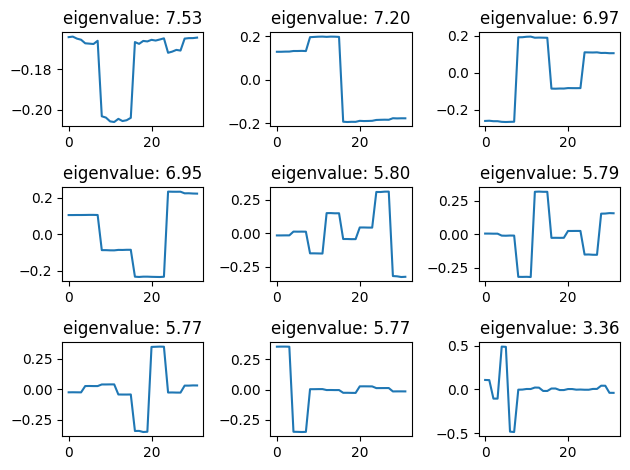

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(range(32), eigvec_b5[:, 0])
axs[0, 0].set_title('eigenvalue: %1.2f' %(eigval_b5[0]))
axs[0, 1].plot(range(32), eigvec_b5[:, 1])
axs[0, 1].set_title('eigenvalue: %1.2f' %(eigval_b5[1]))
axs[0, 2].plot(range(32), eigvec_b5[:, 2])
axs[0, 2].set_title('eigenvalue: %1.2f' %(eigval_b5[2]))
axs[1, 0].plot(range(32), eigvec_b5[:, 3])
axs[1, 0].set_title('eigenvalue: %1.2f' %(eigval_b5[3]))
axs[1, 1].plot(range(32), eigvec_b5[:, 4])
axs[1, 1].set_title('eigenvalue: %1.2f' %(eigval_b5[4]))
axs[1, 2].plot(range(32), eigvec_b5[:, 5])
axs[1, 2].set_title('eigenvalue: %1.2f' %(eigval_b5[5]))
axs[2, 0].plot(range(32), eigvec_b5[:, 6])
axs[2, 0].set_title('eigenvalue: %1.2f' %(eigval_b5[6]))
axs[2, 1].plot(range(32), eigvec_b5[:, 7])
axs[2, 1].set_title('eigenvalue: %1.2f' %(eigval_b5[7]))
axs[2, 2].plot(range(32), eigvec_b5[:, 8])
axs[2, 2].set_title('eigenvalue: %1.2f' %(eigval_b5[8]))
fig.tight_layout()

Next, we save the eigenvalues' information for further data analysis in *R*.

In [22]:
df_b_eigvals = pd.DataFrame({"1": eigval_b1, "2": eigval_b2,
                                "3": eigval_b3, "4": eigval_b4,
                                "5": eigval_b5, "6": eigval_b6,
                                "7": eigval_b7})
df_b_eigvals.to_csv("b_eigvals_10000.csv", index=False)

## 2. Comb Tree

### 2.1 Import Libraries

In [24]:
import numpy as np
import pandas as pd
import itertools
import math
import random
import copy
from _collections import defaultdict
from itertools import product

### 2.2 Comb Tree Class

In this section, we show how to use the defined *CombTree* class to simulate evolutionary results. The defined class has 5 instance variables:

- *seq_len*: length of evolving root sequence

- *p*: parameter to weigh the possibility for A, T, C, and G

- *ntip*: total number of tips in the comb tree

- *lam*: parameter in the JC69 model

- *rand_seed*: random seed to control the randomness in root sequence initilization

In [25]:
class CombTree:
    def __init__(self, seq_len, p, ntip, lam, rand_seed):
        self.seq_len = seq_len  # length of the initial sequence (sequence of the root)

        self.p = p  # mixing parameter for nucleotides to generate the sequence at the root

        self.ntip = ntip  # total number of tips in the comb tree

        self.lam = lam  # only parameter in JC model

        self.seed = rand_seed  # random seed for generating the initial sequence

    def rand_seq(self):  # generate a random initial state
        random.seed(self.seed)
        seq = ['A', 'T', 'C', 'G']
        return ''.join(random.choices(seq, weights=(self.p[0], self.p[1], self.p[2], self.p[3]), k=self.seq_len))

    def evolve(self, sequence, dist):
        p0 = 0.25 + 0.75 * math.exp(-4 * self.lam * dist)  # no mutation

        full = {'A', 'T', 'C', 'G'}
        res = []

        for i in range(len(sequence)):
            if np.random.uniform() > p0:
                res.extend(random.sample(full - set(sequence[i]), k=1))
            else:
                res.append(sequence[i])

        return res

    def evolve_map(self):  # build a hash-map with keys being nodes and values being expression
        seg = 1 / 2 / (self.ntip - 1)  # shortest branch length in the comb tree

        node = [i for i in range(self.ntip * 2 - 2)]

        dic = defaultdict(list)
        # initialize the first evolution from the root
        root_seq = self.rand_seq()
        dic['#' + str(0)] = self.evolve(root_seq, 1 / 2)
        dic['#' + str(1)] = self.evolve(root_seq, seg)

        for j in range(2, self.ntip * 2 - 2, 2):
            # "left" evolve
            left_edge_len = ((self.ntip * 2 - 2) / 2 - j / 2) * seg
            dic['#' + str(int(j))] = self.evolve(dic['#' + str(int(j - 1))], left_edge_len)
            # "right" evolve
            dic['#' + str(int(j + 1))] = self.evolve(dic['#' + str(int(j - 1))], seg)

        return dic

    def count_mers(self, sequence, mer):
        i = 0
        cnt = 0
        while i + len(mer) - 1 < len(sequence):
            if sequence[i:(i + len(mer))] == mer:
                cnt += 1
            i += 1
        return cnt

    def sim_mmt_kmer(self, k):
        one_sim = self.evolve_map()

        tips = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

        M = np.empty(shape=(len(tips), 4 ** k))
        letters = ['A', 'T', 'C', 'G']
        mers = [''.join(letter) for letter in product(letters, repeat=k)]

        # source:
        # https://stackoverflow.com/questions/7074051/what-is-the-best-way-to-generate-all-possible-three-letter-strings

        for i in range(len(tips)):
            for j in range(len(mers)):
                M[i][j] = self.count_mers(''.join(one_sim['#' + str(int(tips[i]))]), mers[j])

        return np.matmul(M, M.transpose())

    def sim_eig(self, nsim, k):
        res = np.zeros(shape=(self.ntip, self.ntip), dtype=float)
        for iter in range(nsim):
            sim_mat = self.sim_mmt_kmer(k)
            res += sim_mat
        mean_mat = res * (1 / nsim)
        eigvals, eigvecs = np.linalg.eigh(mean_mat)
        rev_eigvals = eigvals[::-1]
        rev_eigvecs = eigvecs[:, ::-1]
        return mean_mat, rev_eigvals, rev_eigvecs

    def one_step_transition_mat(self, dist):  # calculate a one step probability transition matrix
        return ([[0.25 + 0.75 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 + 0.75 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 + 0.75 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist)],
                 [0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 - 0.25 * math.exp(-4 * self.lam * dist),
                  0.25 - 0.25 * math.exp(-4 * self.lam * dist), 0.25 + 0.75 * math.exp(-4 * self.lam * dist)]])

    def edge_mat_map(self):  # build a hash-map with keys being edge length and values being one step trans matrix
        seg = 1 / 2 / (self.ntip - 1)  # shortest branch length in the comb tree
        edge_len = [seg]

        for i in range(2, self.ntip):
            edge_len.append(i * seg)

        # construct a hash map with keys being one step branch length
        # and values being one step transition matrix
        dic = defaultdict(list)

        for edge in edge_len:
            dic[edge] = self.one_step_transition_mat(edge)

        return dic

    # node1: integer-valued representation for node1
    # node2: integer-valued representation for node2
    # tips are coded with even numbers (except for the rightmost tip); odds number for internal nodes
    def trans_prob_mat(self, dic, node1, node2):  # calculate all the prob transition matrix
        if node1 == 0 and node2 != 0:
            # initialize identity matrices
            # mat_full_node1: from root to node1
            # mat_full_node2: from root to node2
            mat_full_node1 = [[1, 0, 0, 0], [0, 1, 0, 0],
                              [0, 0, 1, 0], [0, 0, 0, 1]]
            mat_full_node2 = [[1, 0, 0, 0], [0, 1, 0, 0],
                              [0, 0, 1, 0], [0, 0, 0, 1]]
            # node1 and node2 fully independent given the root node
            seg = 1 / 2 / len(dic)
            mat_full_node1 = np.matmul(mat_full_node1, dic[0.5])
            for i in range(1, math.floor(node2 / 2) + 1):
                mat_full_node2 = np.matmul(mat_full_node2, dic[seg])
                # till here, we precede to the closest ancestor of node2

                # then, from closest ancestor to node2
            mat_full_node2 = np.matmul(mat_full_node2, dic[seg * (len(dic) - math.floor(node2 / 2))])
            return mat_full_node1, mat_full_node2
        elif node1 == node2:
            # transition mat for node1 and 2 are exactly the same
            mat_full_node1 = [[1, 0, 0, 0], [0, 1, 0, 0],
                              [0, 0, 1, 0], [0, 0, 0, 1]]
            if node1 == 0:
                mat_full_node1 = np.matmul(mat_full_node1, dic[0.5])
                return mat_full_node1
            # when common node is not the rightmost one
            else:
                seg = 1 / 2 / len(dic)
                for i in range(1, math.floor(node1 / 2) + 1):
                    mat_full_node1 = np.matmul(mat_full_node1, dic[seg])
                    # till here, we precede to the closest ancestor of node1

                # then, from closest ancestor to node1
                mat_full_node1 = np.matmul(mat_full_node1, dic[seg * (len(dic) - math.floor(node1 / 2))])
                return mat_full_node1
        else:
            # mat_root_to_close: from root to a closest common ancestral node
            # mat_close_to_node1: from closest common ancestor to node1
            # mat_close_to_node2: from closest common ancestor to node2
            mat_root_to_close = [[1, 0, 0, 0], [0, 1, 0, 0],
                                 [0, 0, 1, 0], [0, 0, 0, 1]]
            mat_close_to_node1 = [[1, 0, 0, 0], [0, 1, 0, 0],
                                  [0, 0, 1, 0], [0, 0, 0, 1]]
            mat_close_to_node2 = [[1, 0, 0, 0], [0, 1, 0, 0],
                                  [0, 0, 1, 0], [0, 0, 0, 1]]
            mat_full_node1 = [[1, 0, 0, 0], [0, 1, 0, 0],
                              [0, 0, 1, 0], [0, 0, 0, 1]]
            mat_full_node2 = [[1, 0, 0, 0], [0, 1, 0, 0],
                              [0, 0, 1, 0], [0, 0, 0, 1]]

            seg = 1 / 2 / len(dic)

            for i in range(1, int(min(node1 / 2, math.floor(node2 / 2))) + 1):
                mat_root_to_close = np.matmul(mat_root_to_close, dic[seg])

            mat_close_to_node1 = np.matmul(mat_close_to_node1, dic[seg * (len(dic) - math.floor(node1 / 2))])

            for i in range(1, math.floor((node2 - node1) / 2) + 1):
                mat_close_to_node2 = np.matmul(mat_close_to_node2, dic[seg])
            mat_close_to_node2 = np.matmul(mat_close_to_node2, dic[seg * (len(dic) - math.floor(node2 / 2))])

            for i in range(1, math.floor(node1 / 2) + 1):
                mat_full_node1 = np.matmul(mat_full_node1, dic[seg])
            mat_full_node1 = np.matmul(mat_full_node1, dic[seg * (len(dic) - math.floor(node1 / 2))])

            for i in range(1, math.floor(node2 / 2) + 1):
                mat_full_node2 = np.matmul(mat_full_node2, dic[seg])
            mat_full_node2 = np.matmul(mat_full_node2, dic[seg * (len(dic) - math.floor(node2 / 2))])

            return mat_root_to_close, mat_close_to_node1, mat_close_to_node2, mat_full_node1, mat_full_node2

    def count_diff_site(self, mer1: str, mer2: str):
        if len(mer1) != len(mer2):
            raise (Exception("Error: two mers should have the same length"))
        cnt = 0
        for i in range(len(mer1)):
            if mer1[i] != mer2[i]:
                cnt += 1
        return cnt

    # records for kmers' index (odd and even) based on a full sequence
    def kmer_pos_table(self, sequence: str, k: int):
        letters = ['A', 'T', 'C', 'G']
        mers = [''.join(letter) for letter in product(letters, repeat=k)]
        dic_odd = defaultdict(tuple)
        dic_even = defaultdict(tuple)
        for i in range(len(sequence) - k + 1):
            if i % 2:
                dic_even[sequence[i:(i + k)]] += (i + 1,)
            else:
                dic_odd[sequence[i:(i + k)]] += (i + 1,)
        return dic_odd, dic_even, mers

    # classify all possible kmer based on hamming distance and returns a hash table
    # with keys being the hamming distance between target_kmer and an arbitrary kmer
    def kmer_class(self, target_kmer: str, all_kmers: [str]):
        dic = defaultdict(list)
        for kmer in all_kmers:
            dic[str(self.count_diff_site(target_kmer, kmer))].append(kmer)
        return dic

    # calculate the g value of a 3-mer
    def g(self, a_3_mer: str):
        cnt = 0
        for i in range(0, 3 - 1):
            if a_3_mer[i] == a_3_mer[i + 1]:
                cnt += 1
        return cnt

    # Given an odd-starting (even-starting) position, count number of non-overlapped
    # even-starting (odd-starting) positions in a tuple.

    def nonoverlapped(self, pos, atuple):
        cnt = 0
        if pos % 2:
            for item in atuple:
                if item != pos - 1 and item != pos + 1:
                    cnt += 1
            return cnt
        else:
            for item in atuple:
                if item != pos - 1 and item != pos + 1:
                    cnt += 1
            return cnt

    # Given a 2mer starting with an odd (even) position, count the number of 2mer that
    # starts with an non-overlapped even (odd) position and with hamming distance 0 or 1 or 2 from given 2mer.

    def count_nonoverlapped(self, mer: str, mers: [str], pos: int, dic_odd, dic_even):
        dic = self.kmer_class(mer, mers)
        sigma_0 = 0
        sigma_1 = 0
        sigma_2 = 0
        if pos % 2:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped(pos, dic_even[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped(pos, dic_even[value])
                    else:
                        sigma_2 += self.nonoverlapped(pos, dic_even[value])
        else:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped(pos, dic_odd[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped(pos, dic_odd[value])
                    else:
                        sigma_2 += self.nonoverlapped(pos, dic_odd[value])
        return sigma_0, sigma_1, sigma_2

    # Given any position, count number of non-overlapped
    # positions in a tuple.

    def nonoverlapped_m1(self, pos, atuple):
        cnt = 0
        for item in atuple:
            if item != pos:
                cnt += 1
        return cnt

    # Given a 2mer, count the number of 2mer that
    # starts with a non-overlapped position and with hamming distance 0 or 1 or 2 from given 2mer.

    def count_nonoverlapped_m1(self, mer: str, mers: [str], pos: int, dic_odd, dic_even):
        dic = self.kmer_class(mer, mers)
        sigma_0 = 0
        sigma_1 = 0
        sigma_2 = 0
        if pos % 2:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped_m1(pos, dic_odd[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped_m1(pos, dic_odd[value])
                    else:
                        sigma_2 += self.nonoverlapped_m1(pos, dic_odd[value])
        else:
            for key in dic:
                for value in dic[key]:
                    if key == '0':
                        sigma_0 += self.nonoverlapped_m1(pos, dic_even[value])
                    elif key == '1':
                        sigma_1 += self.nonoverlapped_m1(pos, dic_even[value])
                    else:
                        sigma_2 += self.nonoverlapped_m1(pos, dic_even[value])
        return sigma_0, sigma_1, sigma_2

    def em1m2(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)
        three_kmer_dic_odd, three_kmer_dic_even, three_mers = self.kmer_pos_table(s0, k + 1)

        # all tips on level "level"
        tip = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):
            for j in range(len(tip)):
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    x = self.trans_prob_mat(dic, tip[i], tip[j])
                    p0 = x[0][0]
                    p1 = x[0][1]
                    c0 = 0
                    c2 = 0
                    c3 = 0
                    mmt[i][j] = 0
                    for key in three_kmer_dic_odd:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_odd[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_odd[key])
                        else:
                            c3 += len(three_kmer_dic_odd[key])
                    for key in three_kmer_dic_even:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_even[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_even[key])
                        else:
                            c3 += len(three_kmer_dic_even[key])
                    # overlapped case
                    mmt[i][j] += c0 * (p1 ** 3 + 3 * p0 * p1 ** 2) + c2 * (p0 * p1 ** 2 + p0 ** 2 * p1 + 2 * p1 ** 3) \
                                 + c3 * (p0 ** 3 + 3 * p1 ** 3)
                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)], two_mers, indx + 1,
                                                                        two_kmer_dic_odd, two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) \
                                                      + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) + p1 ** 2 * (
                                                     9 * sig0 * p1 ** 2 \
                                                     + sig2 * (p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (
                                                                 3 * p0 * p1 + 6 * p1 ** 2))
                else:
                    if i == 0 and j != 0:
                        x, y = self.trans_prob_mat(dic, tip[i], tip[j])  # mat_full_node1, mat_full_node2
                        p0cr = 1
                        p1cr = 0
                        p0cu = x[0][0]
                        p1cu = x[0][1]
                        p0cv = y[0][0]
                        p1cv = y[0][1]
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                    else:
                        # mat_root_to_close, mat_close_to_node1, mat_close_to_node2, mat_full_node1, mat_full_node2
                        v, w, x, y, z = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0cr = v[0][0]
                        p1cr = v[0][1]
                        p0cu = w[0][0]
                        p1cu = w[0][1]
                        p0cv = x[0][0]
                        p1cv = x[0][1]
                        p0x = y[0][0]
                        p1x = y[0][1]
                        p0y = z[0][0]
                        p1y = z[0][1]
                    mmt[i][j] = 0

                    # overlapped case
                    for key in three_kmer_dic_odd:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                    for key in three_kmer_dic_even:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)

                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)],
                                                                        two_mers, indx + 1,
                                                                        two_kmer_dic_odd,
                                                                        two_kmer_dic_even)
                            mmt[i][j] += p0x ** 2 * (sig0 * p0y ** 2 + sig1 * p0y * p1y + sig2 * p1y ** 2) \
                                         + p0x * p1x * (6 * sig0 * p0y * p1y + sig1 * (
                                        p0y ** 2 + 2 * p0y * p1y + 3 * p1y ** 2) \
                                                        + sig2 * (2 * p0y * p1y + 4 * p1y ** 2)) + p1x ** 2 * (
                                                     9 * sig0 * p1y ** 2 \
                                                     + sig2 * (p0y ** 2 + 4 * p0y * p1y + 4 * p1y ** 2) + sig1 * (
                                                                 3 * p0y * p1y + 6 * p1y ** 2))
        return mmt

    def em2m1(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)
        three_kmer_dic_odd, three_kmer_dic_even, three_mers = self.kmer_pos_table(s0, k + 1)

        # all tips on level "level"
        tip = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):
            for j in range(len(tip)):
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    x = self.trans_prob_mat(dic, tip[i], tip[j])
                    p0 = x[0][0]
                    p1 = x[0][1]
                    c0 = 0
                    c2 = 0
                    c3 = 0
                    mmt[i][j] = 0
                    for key in three_kmer_dic_odd:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_odd[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_odd[key])
                        else:
                            c3 += len(three_kmer_dic_odd[key])
                    for key in three_kmer_dic_even:
                        if len(set(key)) == 3:
                            c0 += len(three_kmer_dic_even[key])
                        elif len(set(key)) == 2:
                            c2 += len(three_kmer_dic_even[key])
                        else:
                            c3 += len(three_kmer_dic_even[key])
                    # overlapped case
                    mmt[i][j] += c0 * (p1 ** 3 + 3 * p0 * p1 ** 2) + c2 * (p0 * p1 ** 2 + p0 ** 2 * p1 + 2 * p1 ** 3) \
                                 + c3 * (p0 ** 3 + 3 * p1 ** 3)
                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)], two_mers, indx + 1,
                                                                        two_kmer_dic_odd, two_kmer_dic_even)
                            mmt[i][j] += p0 ** 2 * (sig0 * p0 ** 2 + sig1 * p0 * p1 + sig2 * p1 ** 2) \
                                         + p0 * p1 * (6 * sig0 * p0 * p1 + sig1 * (p0 ** 2 + 2 * p0 * p1 + 3 * p1 ** 2) \
                                                      + sig2 * (2 * p0 * p1 + 4 * p1 ** 2)) + p1 ** 2 * (
                                                     9 * sig0 * p1 ** 2 \
                                                     + sig2 * (p0 ** 2 + 4 * p0 * p1 + 4 * p1 ** 2) + sig1 * (
                                                                 3 * p0 * p1 + 6 * p1 ** 2))
                else:
                    if i == 0 and j != 0:
                        x, y = self.trans_prob_mat(dic, tip[i], tip[j])  # mat_full_node1, mat_full_node2
                        p0cr = 1
                        p1cr = 0
                        p0cu = x[0][0]
                        p1cu = x[0][1]
                        p0cv = y[0][0]
                        p1cv = y[0][1]
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                    else:
                        # mat_root_to_close, mat_close_to_node1, mat_close_to_node2, mat_full_node1, mat_full_node2
                        v, w, x, y, z = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0cr = v[0][0]
                        p1cr = v[0][1]
                        p0cu = w[0][0]
                        p1cu = w[0][1]
                        p0cv = x[0][0]
                        p1cv = x[0][1]
                        p0x = y[0][0]
                        p1x = y[0][1]
                        p0y = z[0][0]
                        p1y = z[0][1]
                    mmt[i][j] = 0

                    # overlapped case
                    for key in three_kmer_dic_odd:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                    for key in three_kmer_dic_even:
                        sub_class = self.kmer_class(key, three_mers)
                        for sub_key in sub_class:
                            if sub_key == '0':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '1':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr ** 2 * p1cr * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '2':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p0cr * p1cr ** 2 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)
                            if sub_key == '3':
                                for mer in sub_class[sub_key]:
                                    if self.g(mer) == 2:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 1:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p0cv * p1cv + p0cu * p1cu * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 3 * p0cu * p1cu * p1cv ** 2 + 3 * p0cu * p1cu ** 2 * p1cv + 6 * p1cu ** 2 * p1cv ** 2)
                                    if self.g(mer) == 0:
                                        mmt[i][j] += p1cr ** 3 * (
                                                    p0cu ** 2 * p1cv ** 2 + p1cu ** 2 * p0cv ** 2 + 2 * p0cu * p1cu * p0cv * p1cv \
                                                    + 4 * p0cu * p1cu * p1cv ** 2 + 4 * p1cu ** 2 * p0cv * p1cv + 4 * p1cu ** 2 * p1cv ** 2)

                    # non-overlapped
                    for indx in range(1, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped(s0[indx:(indx + k)],
                                                                        two_mers, indx + 1,
                                                                        two_kmer_dic_odd,
                                                                        two_kmer_dic_even)
                            mmt[i][j] += p0x ** 2 * (sig0 * p0y ** 2 + sig1 * p0y * p1y + sig2 * p1y ** 2) \
                                         + p0x * p1x * (6 * sig0 * p0y * p1y + sig1 * (
                                        p0y ** 2 + 2 * p0y * p1y + 3 * p1y ** 2) \
                                                        + sig2 * (2 * p0y * p1y + 4 * p1y ** 2)) + p1x ** 2 * (
                                                     9 * sig0 * p1y ** 2 \
                                                     + sig2 * (p0y ** 2 + 4 * p0y * p1y + 4 * p1y ** 2) + sig1 * (
                                                                 3 * p0y * p1y + 6 * p1y ** 2))
        return mmt

    def em1m1(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)

        # all tips on level "level"
        tip = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):
            for j in range(len(tip)):
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    x = self.trans_prob_mat(dic, tip[i], tip[j])
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    for mer in two_mers:
                        sub_class = self.kmer_class(mer, two_mers)
                        c0 = 0
                        c1 = 0
                        c2 = 0
                        for key in sub_class:
                            if key == '0':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c0 += len(two_kmer_dic_odd[item])
                            if key == '1':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c1 += len(two_kmer_dic_odd[item])
                            if key == '2':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c2 += len(two_kmer_dic_odd[item])
                        ex = c0 * p0 ** 2 + c1 * p1 * p0 + c2 * p1 ** 2
                        varx = c0 * p0 ** 2 * (1 - p0 ** 2) + c1 * p1 * p0 * (1 - p0 * p1) + c2 * p1 ** 2 * (
                                1 - p1 ** 2)
                        mmt[i][j] += varx + ex ** 2

                else:
                    if i == 0 and j != 0:
                        x, y = self.trans_prob_mat(dic, tip[i], tip[j])  # mat_full_node1, mat_full_node2
                        p0cr = 1
                        p1cr = 0
                        p0cu = x[0][0]
                        p1cu = x[0][1]
                        p0cv = y[0][0]
                        p1cv = y[0][1]
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                    else:
                        # mat_root_to_close, mat_close_to_node1, mat_close_to_node2, mat_full_node1, mat_full_node2
                        v, w, x, y, z = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0cr = v[0][0]
                        p1cr = v[0][1]
                        p0cu = w[0][0]
                        p1cu = w[0][1]
                        p0cv = x[0][0]
                        p1cv = x[0][1]
                        p0x = y[0][0]
                        p1x = y[0][1]
                        p0y = z[0][0]
                        p1y = z[0][1]
                    mmt[i][j] = 0
                    # overlapped sites
                    mmt[i][j] += math.floor(self.seq_len / 2) * (
                                p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2) \
                                 * (p0cr ** 2 + 6 * p0cr * p1cr + 9 * p1cr ** 2)

                    # non-overlapped
                    for indx in range(0, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped_m1(s0[indx:(indx + k)],
                                                                           two_mers, indx + 1,
                                                                           two_kmer_dic_odd,
                                                                           two_kmer_dic_even)
                            mmt[i][j] += p0x ** 2 * (sig0 * p0y ** 2 + sig1 * p0y * p1y + sig2 * p1y ** 2) \
                                         + p0x * p1x * (6 * sig0 * p0y * p1y + sig1 * (
                                        p0y ** 2 + 2 * p0y * p1y + 3 * p1y ** 2) \
                                                        + sig2 * (2 * p0y * p1y + 4 * p1y ** 2)) + p1x ** 2 * (
                                                     9 * sig0 * p1y ** 2 \
                                                     + sig2 * (p0y ** 2 + 4 * p0y * p1y + 4 * p1y ** 2) + sig1 * (
                                                                 3 * p0y * p1y + 6 * p1y ** 2))
        return mmt

    def em2m2(self, k=2):
        s0 = self.rand_seq()
        two_kmer_dic_odd, two_kmer_dic_even, two_mers = self.kmer_pos_table(s0, k)

        # all tips on level "level"
        tip = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

        # preallocate
        mmt = np.empty(shape=(len(tip), len(tip)))
        dic = self.edge_mat_map()

        for i in range(len(tip)):
            for j in range(len(tip)):
                if j < i:
                    mmt[i][j] = mmt[j][i]
                elif i == j:
                    x = self.trans_prob_mat(dic, tip[i], tip[j])
                    p0 = x[0][0]
                    p1 = x[0][1]
                    mmt[i][j] = 0
                    for mer in two_mers:
                        sub_class = self.kmer_class(mer, two_mers)
                        c0 = 0
                        c1 = 0
                        c2 = 0
                        for key in sub_class:
                            if key == '0':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c0 += len(two_kmer_dic_odd[item])
                            if key == '1':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c1 += len(two_kmer_dic_odd[item])
                            if key == '2':
                                for item in sub_class[key]:
                                    if item in two_kmer_dic_odd:
                                        c2 += len(two_kmer_dic_odd[item])
                        ex = c0 * p0 ** 2 + c1 * p1 * p0 + c2 * p1 ** 2
                        varx = c0 * p0 ** 2 * (1 - p0 ** 2) + c1 * p1 * p0 * (1 - p0 * p1) + c2 * p1 ** 2 * (
                                1 - p1 ** 2)
                        mmt[i][j] += varx + ex ** 2

                else:
                    if i == 0 and j != 0:
                        x, y = self.trans_prob_mat(dic, tip[i], tip[j])  # mat_full_node1, mat_full_node2
                        p0cr = 1
                        p1cr = 0
                        p0cu = x[0][0]
                        p1cu = x[0][1]
                        p0cv = y[0][0]
                        p1cv = y[0][1]
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                    else:
                        # mat_root_to_close, mat_close_to_node1, mat_close_to_node2, mat_full_node1, mat_full_node2
                        v, w, x, y, z = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0cr = v[0][0]
                        p1cr = v[0][1]
                        p0cu = w[0][0]
                        p1cu = w[0][1]
                        p0cv = x[0][0]
                        p1cv = x[0][1]
                        p0x = y[0][0]
                        p1x = y[0][1]
                        p0y = z[0][0]
                        p1y = z[0][1]
                    mmt[i][j] = 0
                    # overlapped sites
                    mmt[i][j] += math.floor(self.seq_len - self.seq_len / 2 - 1) \
                                 * (p0cu ** 2 * p0cv ** 2 + 6 * p0cu * p1cu * p0cv * p1cv + 9 * p1cu ** 2 * p1cv ** 2) \
                                 * (p0cr ** 2 + 6 * p0cr * p1cr + 9 * p1cr ** 2)

                    # non-overlapped
                    for indx in range(1, self.seq_len, 2):
                        if indx + 1 < self.seq_len:
                            sig0, sig1, sig2 = self.count_nonoverlapped_m1(s0[indx:(indx + k)],
                                                                           two_mers, indx + 1,
                                                                           two_kmer_dic_odd,
                                                                           two_kmer_dic_even)
                            mmt[i][j] += p0x ** 2 * (sig0 * p0y ** 2 + sig1 * p0y * p1y + sig2 * p1y ** 2) \
                                         + p0x * p1x * (6 * sig0 * p0y * p1y + sig1 * (
                                        p0y ** 2 + 2 * p0y * p1y + 3 * p1y ** 2) \
                                                        + sig2 * (2 * p0y * p1y + 4 * p1y ** 2)) + p1x ** 2 * (
                                                     9 * sig0 * p1y ** 2 \
                                                     + sig2 * (p0y ** 2 + 4 * p0y * p1y + 4 * p1y ** 2) + sig1 * (
                                                                 3 * p0y * p1y + 6 * p1y ** 2))
        return mmt

    def emm(self, k):  # calculate E(MM^T) -- tree branch length: expected evolutionary distance
        s0 = self.rand_seq()

        if k != 1 and k != 2:
            raise (Exception("Error: only for k = 1 or 2"))
        if k == 1:
            sigma_k = np.zeros(shape=4)
            sigma_k[0] = s0.count('A')
            sigma_k[1] = s0.count('T')
            sigma_k[2] = s0.count('C')
            sigma_k[3] = s0.count('G')

            # all tips on level "level"
            tip = list(itertools.chain(range(0, 2 * self.ntip - 2, 2), [2 * self.ntip - 3]))

            # preallocate
            mmt = np.empty(shape=(len(tip), len(tip)))
            dic = self.edge_mat_map()

            for i in range(len(tip)):
                for j in range(len(tip)):
                    if i == j:
                        # calculate variance
                        x = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0 = x[0][0]
                        p1 = x[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += k * (1 - p0) * p0 + (self.seq_len - k) * p1 * (1 - p1) + (
                                    k * p0 + (self.seq_len - k) * p1) ** 2
                    elif j < i:
                        mmt[i][j] = mmt[j][i]
                    elif i == 0 and j != 0:
                        x, y = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += (k * p0x + (self.seq_len - k) * p1x) * (k * p0y + (self.seq_len - k) * p1y)
                    else:
                        v, w, x, y, z = self.trans_prob_mat(dic, tip[i], tip[j])
                        p0v = v[0][0]
                        p1v = v[0][1]
                        p0w = w[0][0]
                        p1w = w[0][1]
                        p0x = x[0][0]
                        p1x = x[0][1]
                        p0y = y[0][0]
                        p1y = y[0][1]
                        p0z = z[0][0]
                        p1z = z[0][1]
                        mmt[i][j] = 0
                        for k in sigma_k:
                            mmt[i][j] += k * (p0v * p0w * p0x + p1v * p1w * p1x) \
                                         + (self.seq_len - k) * (p1v * p0w * p0x + p0v * p1w * p1x) \
                                         + k * (p0y * ((k - 1) * p0z + (self.seq_len - k) * p1z)) \
                                         + (self.seq_len - k) * (p1y * (k * p0z + (self.seq_len - k - 1) * p1z))
            return mmt
        else:
            return self.em1m1() + self.em2m2() + self.em1m2() + self.em2m1()


### 2.3 Simulated Data for Comb Tree

To simulate evolutionary results and to estimate $MM^{T}$, we first instantiate the *CombTree* class:

In [27]:
c = CombTree(7, [25, 25, 25, 25], 32, 1, 1)

Next, we use *sim_eig(nsim, k)* method to get the Monte Carlo estimate of $MM^T$, and its corresponding eigenvalues and eigenvectors. The two parameters in this method are:

- *nsim*: number of random Monte Carlo experiments
- *k*: value of k in k-mer analysis; the minimum is 1 and the maximum is length of the sequence

Since the matrix $M$ is affected by the choice of $k$ in k-mer analysis, to see the eigen-structure for the full range of $k = 7$, we do the followings:

In [29]:
%%time
Q_c1, eigval_c1, eigvec_c1 = c.sim_eig(10000, 1)

Q_c2, eigval_c2, eigvec_c2 = c.sim_eig(10000, 2)

Q_c3, eigval_c3, eigvec_c3 = c.sim_eig(10000, 3)

Q_c4, eigval_c4, eigvec_c4 = c.sim_eig(10000, 4)

Q_c5, eigval_c5, eigvec_c5 = c.sim_eig(10000, 5)

Q_c6, eigval_c6, eigvec_c6 = c.sim_eig(10000, 6)

Q_c7, eigval_c7, eigvec_c7 = c.sim_eig(10000, 7)

CPU times: user 2h 24min 47s, sys: 19 s, total: 2h 25min 6s
Wall time: 14h 5min 32s


To see the eigen-structure of estimates of $E(MM^T)$, we plot 9 largest eigenvectors. For comb tree, we observe that the eigenvectors behave differently for different values of $k$. For smaller $k = 1,2,3$, the first eigenvector is approximately an average across all the taxa. The second eigenvector can be described as a combination of two wavelets: one that is high frequency and that has largest amplitude for the left half of the tree where the taxa are most distinct, and one that is low frequency and has largest amplitude to the right of the tree where the taxa are least distinct.

Below is the plot of first to ninth largest eigenvectors when $k = 2$.

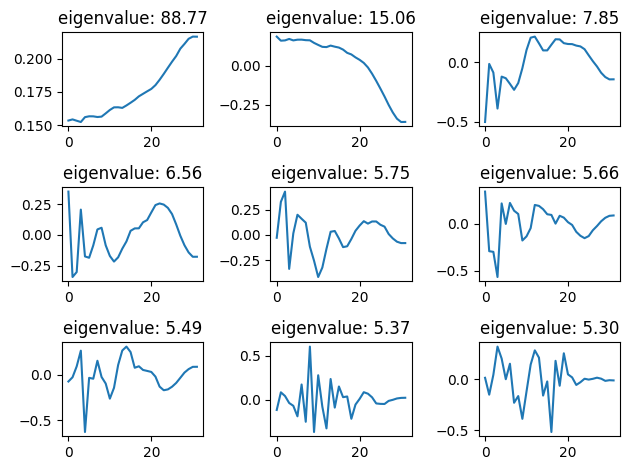

In [34]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(range(32), eigvec_c2[:, 0])
axs[0, 0].set_title('eigenvalue: %1.2f' %(eigval_c2[0]))
axs[0, 1].plot(range(32), eigvec_c2[:, 1])
axs[0, 1].set_title('eigenvalue: %1.2f' %(eigval_c2[1]))
axs[0, 2].plot(range(32), eigvec_c2[:, 2])
axs[0, 2].set_title('eigenvalue: %1.2f' %(eigval_c2[2]))
axs[1, 0].plot(range(32), eigvec_c2[:, 3])
axs[1, 0].set_title('eigenvalue: %1.2f' %(eigval_c2[3]))
axs[1, 1].plot(range(32), eigvec_c2[:, 4])
axs[1, 1].set_title('eigenvalue: %1.2f' %(eigval_c2[4]))
axs[1, 2].plot(range(32), eigvec_c2[:, 5])
axs[1, 2].set_title('eigenvalue: %1.2f' %(eigval_c2[5]))
axs[2, 0].plot(range(32), eigvec_c2[:, 6])
axs[2, 0].set_title('eigenvalue: %1.2f' %(eigval_c2[6]))
axs[2, 1].plot(range(32), eigvec_c2[:, 7])
axs[2, 1].set_title('eigenvalue: %1.2f' %(eigval_c2[7]))
axs[2, 2].plot(range(32), eigvec_c2[:, 8])
axs[2, 2].set_title('eigenvalue: %1.2f' %(eigval_c2[8]))
fig.tight_layout()

For larger $k = 4, 5, 6, 7$, The first eigenvector is approximately an indicator of the three or four right-most taxa, the second is approximately a contrast between those taxa and their three or four closest neighbors, and so on.

Below is the plot of first to ninth largest eigenvectors when $k = 6$.

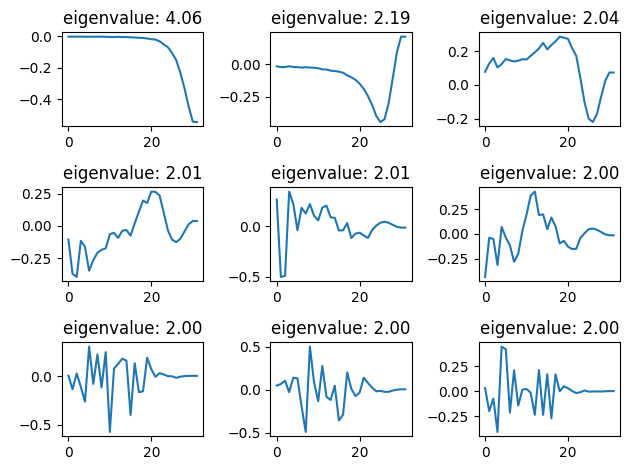

In [35]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(range(32), eigvec_c6[:, 0])
axs[0, 0].set_title('eigenvalue: %1.2f' %(eigval_c6[0]))
axs[0, 1].plot(range(32), eigvec_c6[:, 1])
axs[0, 1].set_title('eigenvalue: %1.2f' %(eigval_c6[1]))
axs[0, 2].plot(range(32), eigvec_c6[:, 2])
axs[0, 2].set_title('eigenvalue: %1.2f' %(eigval_c6[2]))
axs[1, 0].plot(range(32), eigvec_c6[:, 3])
axs[1, 0].set_title('eigenvalue: %1.2f' %(eigval_c6[3]))
axs[1, 1].plot(range(32), eigvec_c6[:, 4])
axs[1, 1].set_title('eigenvalue: %1.2f' %(eigval_c6[4]))
axs[1, 2].plot(range(32), eigvec_c6[:, 5])
axs[1, 2].set_title('eigenvalue: %1.2f' %(eigval_c6[5]))
axs[2, 0].plot(range(32), eigvec_c6[:, 6])
axs[2, 0].set_title('eigenvalue: %1.2f' %(eigval_c6[6]))
axs[2, 1].plot(range(32), eigvec_c6[:, 7])
axs[2, 1].set_title('eigenvalue: %1.2f' %(eigval_c6[7]))
axs[2, 2].plot(range(32), eigvec_c6[:, 8])
axs[2, 2].set_title('eigenvalue: %1.2f' %(eigval_c6[8]))
fig.tight_layout()

Next, we save the first to third largest eigenvectors for different values of $k$ and the eigenvalues for further analysis in *R*.

In [36]:
df_comb_largest = pd.DataFrame({"k1": eigvec_c1[:, 0], "k2": eigvec_c2[:, 0],
                                "k3": eigvec_c3[:, 0], "k4": -eigvec_c4[:, 0],
                                "k5": -eigvec_c5[:, 0], "k6": -eigvec_c6[:, 0],
                                "k7": -eigvec_c7[:, 0]})
df_comb_largest.to_csv("comb_largest_10000.csv", index=False)

df_comb_second = pd.DataFrame({"k1": -eigvec_c1[:, 1], "k2": eigvec_c2[:, 1],
                                "k3": -eigvec_c3[:, 1], "k4": -eigvec_c4[:, 1],
                                "k5": eigvec_c5[:, 1], "k6": eigvec_c6[:, 1],
                                "k7": eigvec_c7[:, 1]})
df_comb_second.to_csv("comb_second_10000.csv", index=False)

df_comb_third = pd.DataFrame({"k1": -eigvec_c1[:, 2], "k2": eigvec_c2[:, 2],
                                "k3": -eigvec_c3[:, 2], "k4": -eigvec_c4[:, 2],
                                "k5": eigvec_c5[:, 2], "k6": eigvec_c6[:, 2],
                                "k7": eigvec_c7[:, 2]})
df_comb_third.to_csv("comb_third_10000.csv", index=False)

df_c_eigvals = pd.DataFrame({"1": eigval_c1, "2": eigval_c2,
                                "3": eigval_c3, "4": eigval_c4,
                                "5": eigval_c5, "6": eigval_c6,
                                "7": eigval_c7})
df_c_eigvals.to_csv("c_eigvals_10000.csv", index=False)

## 3. Real Tree

### 3.1 Import Libraries

In [38]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from itertools import product
import pyvolve

### 3.2 Read Tree Files and Simulate Data

In [41]:
real_tree = pyvolve.read_tree(file='real_tree.xml')

Define a function to estimate $E(MM^T)$. The function takes 3 parameters:

- *nsim*: number of random Monte Carlo experiments
- *ntip*: total number of tips in the real tree
- *k*: value of k in k-mer analysis; the minimum is 1 and the maximum is length of the sequence

In [42]:
def sim_real_tree(nsim, ntip, k):
    letters = ['A', 'T', 'C', 'G']
    mers = [''.join(letter) for letter in product(letters, repeat=k)]

    def count_mers(sequence: str, mer: str):  # count the frequency of mer in a sequence
        i = 0
        cnt = 0
        while i + len(mer) - 1 < len(sequence):
            if sequence[i:(i + len(mer))] == mer:
                cnt += 1
            i += 1
        return cnt

    M_0 = coo_matrix((ntip, ntip), dtype=float).toarray()
    for sim in range(nsim):
        i = 0
        my_model = pyvolve.Model('nucleotide')
        my_partition = pyvolve.Partition(models=my_model, root_sequence="GATAGAA")
        my_evolver = pyvolve.Evolver(partitions=my_partition, tree=real_tree)
        my_evolver()
        seq_dict = {rec.id: rec.seq for rec in SeqIO.parse("./simulated_alignment.fasta", "fasta")}
        M = coo_matrix((len(seq_dict), 4 ** k), dtype=float).toarray()
        for key in seq_dict:
            for j in range(len(mers)):
                M[i][j] = count_mers(seq_dict[key], mers[j])
            i += 1
        M_0 += np.matmul(M, M.transpose())
    return M_0 * 1 / nsim


Again, we estimate $E(MM^T)$ for different $k$ values.

In [45]:
mat1 = sim_real_tree(10000, 50, 1)

mat2 = sim_real_tree(10000, 50, 2)

mat3 = sim_real_tree(10000, 50, 3)

mat4 = sim_real_tree(10000, 50, 4)

mat5 = sim_real_tree(10000, 50, 5)

mat6 = sim_real_tree(10000, 50, 6)

mat7 = sim_real_tree(10000, 50, 7)

Define a function to get the eigenvalues and eigenvectors.

In [46]:
def eigen(mat):
    eigvals, eigvecs = np.linalg.eigh(mat)
    rev_eigvals = eigvals[::-1]
    rev_eigvecs = eigvecs[:, ::-1]
    return rev_eigvals, rev_eigvecs

In [47]:
mat1_val, mat1_vec = eigen(mat1)
mat2_val, mat2_vec = eigen(mat2)
mat3_val, mat3_vec = eigen(mat3)
mat4_val, mat4_vec = eigen(mat4)
mat5_val, mat5_vec = eigen(mat5)
mat6_val, mat6_vec = eigen(mat6)
mat7_val, mat7_vec = eigen(mat7)

Below is the plot of first to ninth largest eigenvectors when $k = 6$.

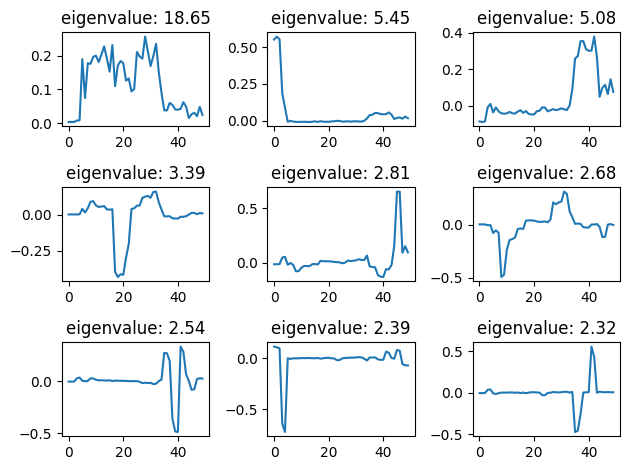

In [48]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(range(50), mat6_vec[:, 0])
axs[0, 0].set_title('eigenvalue: %1.2f' %(mat6_val[0]))
axs[0, 1].plot(range(50), mat6_vec[:, 1])
axs[0, 1].set_title('eigenvalue: %1.2f' %(mat6_val[1]))
axs[0, 2].plot(range(50), mat6_vec[:, 2])
axs[0, 2].set_title('eigenvalue: %1.2f' %(mat6_val[2]))
axs[1, 0].plot(range(50), mat6_vec[:, 3])
axs[1, 0].set_title('eigenvalue: %1.2f' %(mat6_val[3]))
axs[1, 1].plot(range(50), mat6_vec[:, 4])
axs[1, 1].set_title('eigenvalue: %1.2f' %(mat6_val[4]))
axs[1, 2].plot(range(50), mat6_vec[:, 5])
axs[1, 2].set_title('eigenvalue: %1.2f' %(mat6_val[5]))
axs[2, 0].plot(range(50), mat6_vec[:, 6])
axs[2, 0].set_title('eigenvalue: %1.2f' %(mat6_val[6]))
axs[2, 1].plot(range(50), mat6_vec[:, 7])
axs[2, 1].set_title('eigenvalue: %1.2f' %(mat6_val[7]))
axs[2, 2].plot(range(50), mat6_vec[:, 8])
axs[2, 2].set_title('eigenvalue: %1.2f' %(mat6_val[8]))
fig.tight_layout()